# 5. Использование нейросетей

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('pollution.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [4]:
df['pm2.5'].isna().sum()

2067

In [5]:
df = df[24:].fillna(method='ffill')
df['pm2.5'].isna().sum()

0

In [6]:
import datetime

df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
df = df.set_index('time')
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [7]:
df['cbwd'].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [8]:
df = df.join((pd.get_dummies(df['cbwd'])).astype(int))
del df['cbwd']
df.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


<Axes: xlabel='time'>

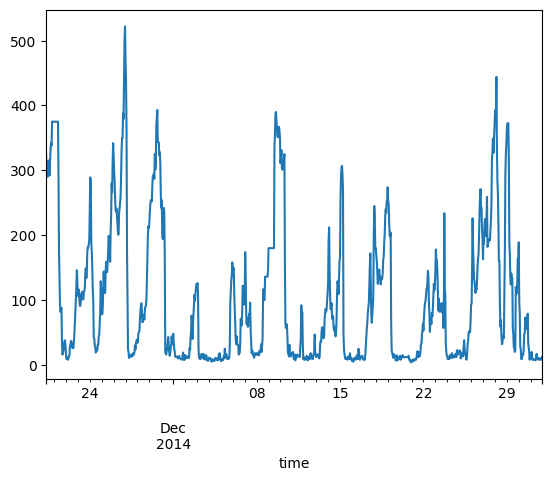

In [9]:
df['pm2.5'][-1000:].plot()

<Axes: xlabel='time'>

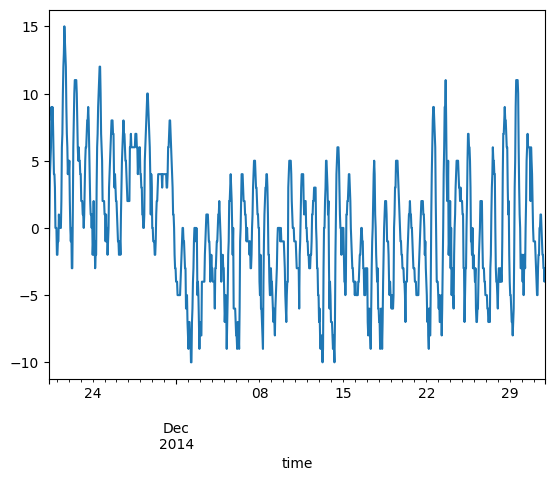

In [10]:
df['TEMP'][-1000:].plot()

In [11]:
seq_len = 5*24
delay = 1*24
df_ = np.array([df.iloc[i : i + seq_len + delay].values for i in range(len(df) - seq_len - delay)])
df_.shape

(43656, 144, 11)

In [12]:
np.random.shuffle(df_)
x = df_[:, :5*24, :]
y = df_[:, -1, 0]
x.shape, y.shape

((43656, 120, 11), (43656,))

In [13]:
split = int(y.shape[0] - 48)
train_x = x[:split]
train_y = y[:split]
test_x = x[split:]
test_y = y[split:]

mean = train_x.mean(axis=0)
std = train_x.std(axis=0)
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

In [14]:
train_x.shape, test_x.shape

((43608, 120, 11), (48, 120, 11))

In [15]:
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(120, 11)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1320)              0         
                                                                 
 dense (Dense)               (None, 32)                42272     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 42305 (165.25 KB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(train_x, train_y, batch_size=128, epochs=50, validation_data=(test_x, test_y))

Epoch 1/50
341/341 [==============================] - 2s 5ms/step - loss: 10432.3340 - mse: 10432.3340 - val_loss: 5919.7305 - val_mse: 5919.7305
Epoch 2/50
341/341 [==============================] - 1s 4ms/step - loss: 7740.9473 - mse: 7740.9473 - val_loss: 5445.9243 - val_mse: 5445.9243
Epoch 3/50
341/341 [==============================] - 1s 4ms/step - loss: 6997.6055 - mse: 6997.6055 - val_loss: 5302.1958 - val_mse: 5302.1958
Epoch 4/50
341/341 [==============================] - 1s 4ms/step - loss: 6616.1445 - mse: 6616.1445 - val_loss: 5032.9033 - val_mse: 5032.9033
Epoch 5/50
341/341 [==============================] - 1s 4ms/step - loss: 6363.2178 - mse: 6363.2178 - val_loss: 5112.6230 - val_mse: 5112.6230
Epoch 6/50
341/341 [==============================] - 2s 5ms/step - loss: 6153.5889 - mse: 6153.5889 - val_loss: 5138.5786 - val_mse: 5138.5786
Epoch 7/50
341/341 [==============================] - 2s 5ms/step - loss: 5964.9766 - mse: 5964.9766 - val_loss: 4937.8071 - val_mse: 

In [18]:
predictions = model.predict(test_x)

2/2 [==============================] - 0s 5ms/step


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [21]:
print(f"rmse на тестовой выборке составило {np.sqrt(mean_squared_error(test_y, predictions))}")

rmse на тестовой выборке составило 53.27111448988087


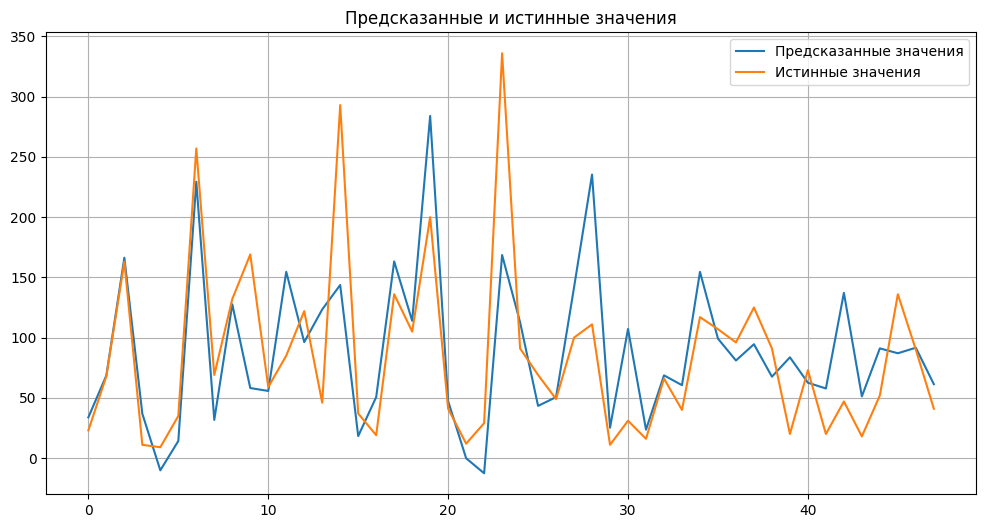

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Предсказанные значения')
plt.plot(test_y, label='Истинные значения')
plt.title('Предсказанные и истинные значения')
plt.grid()
plt.legend()
plt.show()

## LSTM Model (Однослойная)


In [23]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(120, 11)))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5632      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5665 (22.13 KB)
Trainable params: 5665 (22.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(train_x, train_y, batch_size=128, epochs=150, validation_data=(test_x, test_y))

Epoch 1/150
341/341 [==============================] - 28s 76ms/step - loss: 15925.4199 - mse: 15925.4199 - val_loss: 9485.8262 - val_mse: 9485.8262
Epoch 2/150
341/341 [==============================] - 23s 66ms/step - loss: 13741.8203 - mse: 13741.8203 - val_loss: 8156.9604 - val_mse: 8156.9604
Epoch 3/150
341/341 [==============================] - 26s 77ms/step - loss: 12325.8379 - mse: 12325.8379 - val_loss: 7173.0117 - val_mse: 7173.0117
Epoch 4/150
341/341 [==============================] - 22s 65ms/step - loss: 11226.5762 - mse: 11226.5762 - val_loss: 6441.9741 - val_mse: 6441.9741
Epoch 5/150
341/341 [==============================] - 21s 62ms/step - loss: 10375.1914 - mse: 10375.1914 - val_loss: 5916.2812 - val_mse: 5916.2812
Epoch 6/150
341/341 [==============================] - 22s 65ms/step - loss: 9724.7188 - mse: 9724.7188 - val_loss: 5546.7524 - val_mse: 5546.7524
Epoch 7/150
341/341 [==============================] - 22s 66ms/step - loss: 9179.3594 - mse: 9179.3594 - va

In [25]:
predictions = model.predict(test_x)

2/2 [==============================] - 1s 16ms/step


In [26]:
print(f"rmse на тестовой выборке составило {np.sqrt(mean_squared_error(test_y, predictions))}")

rmse на тестовой выборке составило 56.47417298076278


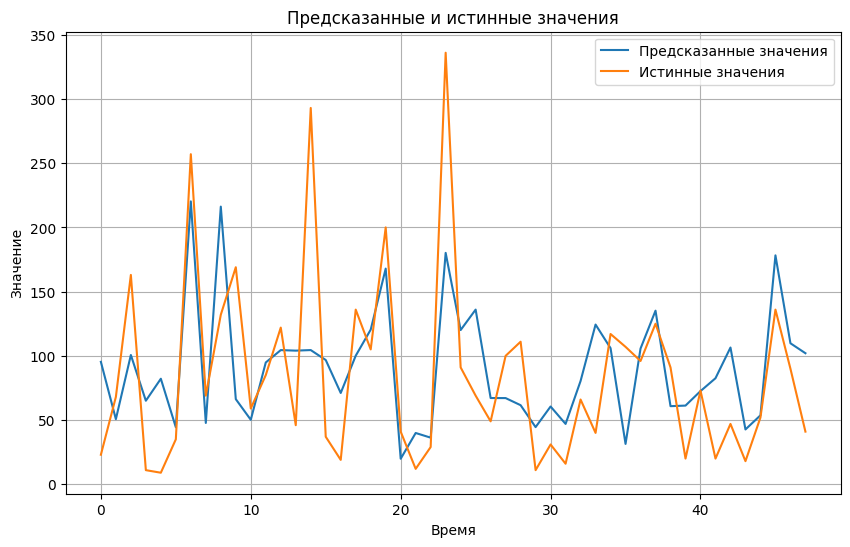

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Предсказанные значения')
plt.plot(test_y, label='Истинные значения')
plt.title('Предсказанные и истинные значения')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.grid()
plt.legend()
plt.show()

## LSTM Model (Многоуровневая)

In [28]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(120, 11), return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 120, 32)           5632      
                                                                 
 lstm_2 (LSTM)               (None, 120, 32)           8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22305 (87.13 KB)
Trainable params: 22305 (87.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
lr_reduced = keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5, min_lr=0.00001)

In [30]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(train_x, train_y, batch_size=128, epochs=150, validation_data=(test_x, test_y), callbacks=[lr_reduced])

Epoch 1/150
341/341 [==============================] - 83s 228ms/step - loss: 15733.0586 - mse: 15733.0586 - val_loss: 9490.8184 - val_mse: 9490.8184 - lr: 0.0010
Epoch 2/150
341/341 [==============================] - 80s 234ms/step - loss: 13778.9561 - mse: 13778.9561 - val_loss: 8202.2588 - val_mse: 8202.2588 - lr: 0.0010
Epoch 3/150
341/341 [==============================] - 77s 227ms/step - loss: 12389.5195 - mse: 12389.5195 - val_loss: 7224.8452 - val_mse: 7224.8452 - lr: 0.0010
Epoch 4/150
341/341 [==============================] - 79s 232ms/step - loss: 11291.7803 - mse: 11291.7803 - val_loss: 6488.2124 - val_mse: 6488.2124 - lr: 0.0010
Epoch 5/150
341/341 [==============================] - 78s 228ms/step - loss: 10433.4795 - mse: 10433.4795 - val_loss: 5953.3618 - val_mse: 5953.3618 - lr: 0.0010
Epoch 6/150
341/341 [==============================] - 78s 230ms/step - loss: 9776.6650 - mse: 9776.6650 - val_loss: 5584.2241 - val_mse: 5584.2241 - lr: 0.0010
Epoch 7/150
341/341 [===

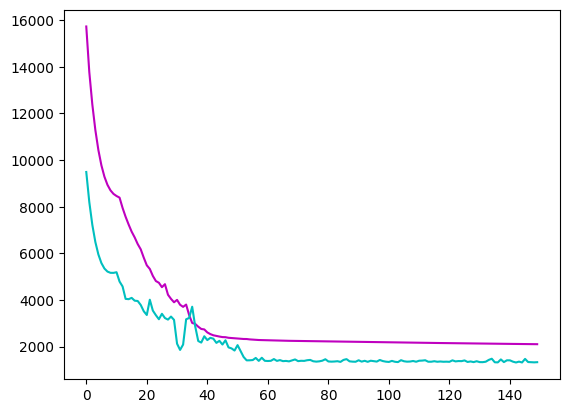

In [31]:
plt.plot(history.epoch, history.history['loss'], c='m')
plt.plot(history.epoch, history.history['val_loss'], c='c')

In [32]:
predictions = model.predict(test_x)

2/2 [==============================] - 2s 45ms/step


In [33]:
print(f"rmse на тестовой выборке составило {np.sqrt(mean_squared_error(test_y, predictions))}")

rmse на тестовой выборке составило 36.49253262091455


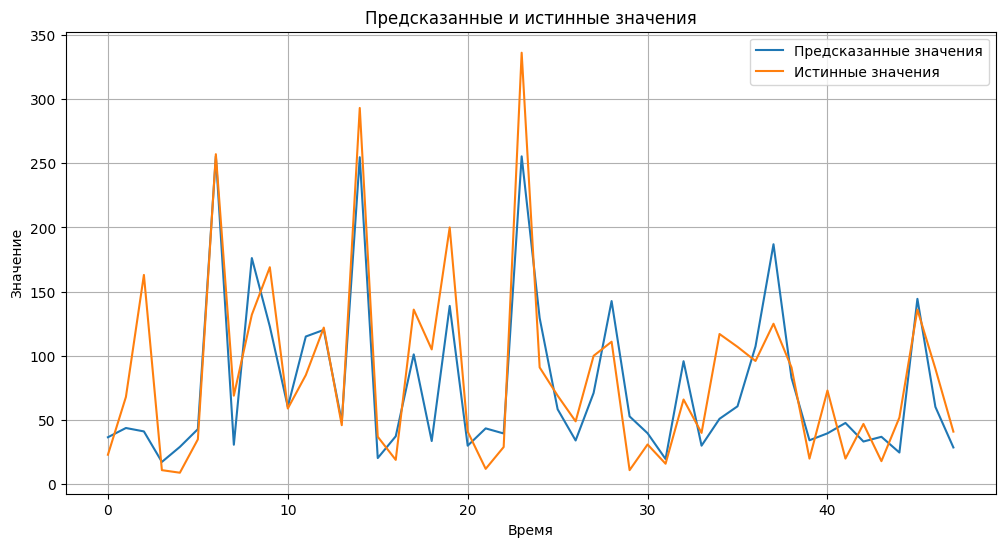

In [34]:
# Визуализация предсказанных и истинных значений
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Предсказанные значения')
plt.plot(test_y, label='Истинные значения')
plt.title('Предсказанные и истинные значения')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.grid()
plt.legend()
plt.show()